# Bayesian Linear Regression Tutorial

## Import code

In [1]:
from bayeslr.bayeslr import *

from scipy.stats import linregress
import matplotlib.pyplot as plt 

# update plot parameters
params = {'legend.fontsize': 12,
          'figure.figsize': (12, 9),
          'lines.linewidth':4,
         'axes.labelsize': 20,
         'axes.titlesize':24,
          'axes.linewidth':4,
         'xtick.labelsize':22,
         'ytick.labelsize':22}
plt.rcParams.update(params)
plt.rcParams['pdf.fonttype'] = 42

## Model definition

Want to predict a single output $y \in \mathbb{R}$ given a vector of features $\mathbf{x} \in \mathbb{R}^d$ 

By defining a basis function $\phi: \mathbb{R}^d \rightarrow \mathbb{R}^m$, the model predicts $y$ as a linear combination of potentially non-linear functions of $\mathbf{x}$, weighted by regression coefficients $\mathbf{w} \in \mathbb{R}^m$.  

$$
y = \mathbf{w}^T \phi (\mathbf{x}) + \varepsilon
$$

The model assumes that measurements are corrupted by zero-mean Gaussian noise with precision $\beta$, 


$$
\varepsilon \sim \mathcal{N}(\varepsilon | 0, \beta^{-1})
$$

## Example with $\phi_i(\mathbf{x}) = x_i$

In this example, Scikit-learn's make_regression() is used to generate synthetic data with 100 features, 1 target variable, and 150 samples. Gaussian noise is added to the output variable with a standard deviation of 10, which corresponds to a precision of $\frac{1}{10^{2}}$ = .01.  

In [93]:
import sklearn.datasets
from sklearn.preprocessing import StandardScaler
import numpy as np

# number of samples
NS = 15
# number of features
NF = 5
# number of important features 
n_important = 5
# define precision as beta
noise = 30      # std deviation 
beta = (1./noise)**2 # inverse variance 

X, y = sklearn.datasets.make_regression(n_samples=NS, n_features=NF, 
                                        n_informative=n_important, 
                                        n_targets=1, noise=noise)

Decompose data set into training and testing data, setting aside 1/5 of the data for testing. 

In [94]:
N_train = int(.5*NS)

X_train = X[:N_train, :] 
X_test = X[N_train:, :]
Y_train = y[:N_train]
Y_test = y[N_train:]

In [95]:
Xscaler = StandardScaler().fit(X_train)
X_train = Xscaler.transform(X_train)
X_test  = Xscaler.transform(X_test)

Yscaler = StandardScaler().fit(np.vstack(Y_train))
Y_train = Yscaler.transform(np.vstack(Y_train)).ravel()
Y_test  = Yscaler.transform(np.vstack(Y_test)).ravel()

Fit a Bayesian linear regression model and maximize evidence function

In [96]:
blr = LR()
blr.fit(X_train, Y_train)

Evidence -4.569
Evidence -2.283
Evidence -0.512
Evidence 1.029
Evidence 2.341
Evidence 3.356
Evidence 4.032
Evidence 4.415
Evidence 4.604
Evidence 4.693
Evidence 4.736
Evidence 4.757
Evidence 4.769
Evidence 4.776
Evidence 4.781
Pass count  1


# Make predictions on test data

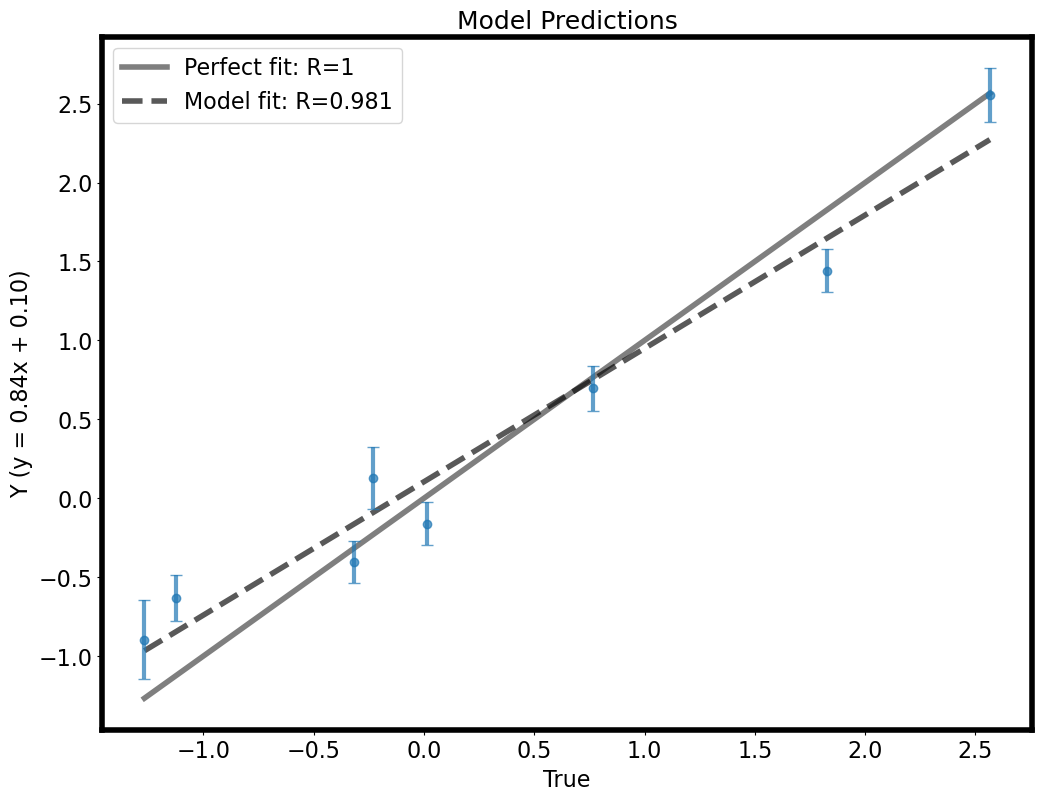

In [97]:
Y, Y_stdv = blr.predict(X_test)

OneToOne = np.linspace(np.min(Y_test), np.max(Y_test), 100)
plt.plot(OneToOne, OneToOne, 'k', alpha=.5, label="Perfect fit: R=1")

lr_stats = linregress(Y_test, Y)
y_fit = OneToOne*lr_stats.slope + lr_stats.intercept

plt.plot(OneToOne, y_fit, 'k--', alpha=.65, label=r"Model fit: R={:.3f}".format(lr_stats.rvalue))
plt.errorbar(Y_test, Y, linewidth=3, capsize=4, linestyle='none', marker='o', alpha=.7, yerr = Y_stdv)

plt.legend(fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("True", fontsize=16)
plt.ylabel("Y (y = {:.2f}x + {:.2f})".format(lr_stats.slope, lr_stats.intercept), fontsize=16)
plt.title(r"Model Predictions", fontsize=18)
plt.savefig("Figures/example_1.png", dpi=100)
plt.show()

In [98]:
@jit
def sample(mu, cov, rng):        
    
    # set rng
    rng_key = random.PRNGKey(rng)
    
    # cholesky factorization of covariance
    L = jnp.linalg.cholesky(cov)
    
    # standard normal random vector
    z = random.normal(rng_key, shape=(len(mu),))
    
    # transform so that sample has E[s] = mu, cov[s] = cov
    return mu + jnp.dot(z, L.T)

@jit
def log_proposal(z, mu, A):
    res = z-mu
    return -1/2*jnp.einsum("i,ij,j", res, A, res)

In [100]:
@jit
def update_precision(alpha, beta, X):
    return alpha * jnp.eye(len(alpha)) + beta * jnp.einsum("ni,nj->ij", X, X)

A = update_precision(blr.alpha, blr.beta, X_train)

In [101]:
def objective(self, params, X, Y):
    # init loss with parameter penalty
    loss = jnp.dot(self.alpha * params, params) / 2.

    # forward pass
    loss += self.compute_NLL(params, X, Y, self.beta)

    return loss

In [102]:
# particle filter steps
# 1. Generate samples from Gaussian posterior
# 2. Compute weights for each sample 
# 3. Resample with replacement using weights 

In [103]:
samples = np.stack([sample(blr.params, np.diag(np.diag(blr.Ainv)), i) for i in range(1000)])

In [104]:
# evaluate log posterior for each sample 
log_p = np.array([-blr.objective(s, X_train, Y_train) for s in samples])

In [105]:
# log prior
log_q = np.array([log_proposal(s, blr.params, A) for s in samples])

In [106]:
Z = log_p - log_q
w = np.exp(Z - np.max(Z)) / np.sum(np.exp(Z - np.max(Z)))
np.sort(w)

array([0.00099999, 0.00099999, 0.00099999, 0.00099999, 0.00099999,
       0.00099999, 0.00099999, 0.00099999, 0.00099999, 0.00099999,
       0.00099999, 0.00099999, 0.00099999, 0.00099999, 0.00099999,
       0.00099999, 0.00099999, 0.00099999, 0.00099999, 0.00099999,
       0.00099999, 0.00099999, 0.00099999, 0.001     , 0.001     ,
       0.001     , 0.001     , 0.001     , 0.001     , 0.001     ,
       0.001     , 0.001     , 0.001     , 0.001     , 0.001     ,
       0.001     , 0.001     , 0.001     , 0.001     , 0.001     ,
       0.001     , 0.001     , 0.001     , 0.001     , 0.001     ,
       0.001     , 0.001     , 0.001     , 0.001     , 0.001     ,
       0.001     , 0.001     , 0.001     , 0.001     , 0.001     ,
       0.001     , 0.001     , 0.001     , 0.001     , 0.001     ,
       0.001     , 0.001     , 0.001     , 0.001     , 0.001     ,
       0.001     , 0.001     , 0.001     , 0.001     , 0.001     ,
       0.001     , 0.001     , 0.001     , 0.001     , 0.001  

In [66]:
sample_inds = np.random.choice(np.arange(len(samples)), p=w, replace=True, size=1000)

In [69]:
np.sort(w)

array([4.80977400e-13, 4.95321395e-13, 5.23317338e-13, 5.55244923e-13,
       6.27412076e-13, 6.28203544e-13, 6.51588267e-13, 6.70342308e-13,
       7.05341655e-13, 7.61890009e-13, 7.71416568e-13, 7.88564797e-13,
       7.89460240e-13, 8.00889682e-13, 8.02815280e-13, 8.04493679e-13,
       8.16050515e-13, 8.57325333e-13, 8.75384184e-13, 9.31950047e-13,
       9.48456916e-13, 9.52318086e-13, 9.65622656e-13, 9.78898386e-13,
       9.82888900e-13, 1.02875705e-12, 1.04210141e-12, 1.05383248e-12,
       1.05529073e-12, 1.07707994e-12, 1.08502031e-12, 1.09546129e-12,
       1.11879668e-12, 1.12181802e-12, 1.12469756e-12, 1.12962732e-12,
       1.13288101e-12, 1.13359658e-12, 1.20756595e-12, 1.20840924e-12,
       1.27309849e-12, 1.29189443e-12, 1.30225290e-12, 1.31993277e-12,
       1.32333326e-12, 1.37047762e-12, 1.38955796e-12, 1.39225068e-12,
       1.45578883e-12, 1.46400318e-12, 1.46781415e-12, 1.47242667e-12,
       1.48417617e-12, 1.50204914e-12, 1.50263081e-12, 1.53463960e-12,
      

In [34]:
Z = np.random.uniform(0, 1, 10)

In [35]:
np.exp(Z) / np.sum(np.exp(Z))

array([0.10837569, 0.07838714, 0.06570879, 0.14012572, 0.08034288,
       0.14552144, 0.07819681, 0.14971778, 0.07067186, 0.08295187])

In [36]:
np.exp(Z - np.max(Z)) / np.sum(np.exp(Z - np.max(Z)))

array([0.10837569, 0.07838714, 0.06570879, 0.14012572, 0.08034288,
       0.14552144, 0.07819681, 0.14971778, 0.07067186, 0.08295187])

In [ ]:
import math 
from scipy.stats import norm

t_dist = lambda x, b: b * np.sqrt(1 / (2*np.pi)) * (b + x**2 / 2) ** (-1.5) * math.gamma(1.5) 
norm_dist = norm(loc=0, scale=np.sqrt(1/blr.beta))

In [ ]:
plt.figure(figsize=(9, 6))
x = np.linspace(-.5, .5, 100)
#plt.plot(x, t_dist(x, 1e-3), linewidth=4)
plt.plot(x, norm_dist.pdf(x), linewidth=4)
plt.hist(Y_test - Y, bins=15, density=True)
# plt.xlim([-.5, .5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Density", fontsize=26)
plt.xlabel(r"$\varepsilon = y - f(x, \theta)$", fontsize=26)
# plt.savefig("Noise_model_validation.pdf")
plt.show()

## Example with $\phi_i(\mathbf{x}) = [1, x_i, x_i^2, ..., x_i^5]^T$

Generate data with response that is non-linear in x

In [ ]:
def f(x, noise):
    return .7*np.sin(5 * x) * (1 - np.tanh(x ** 2)) + np.random.randn() * noise/100

def generate_data(Xlist, noise=0.):
    Nsamples = len(Xlist)
    X = np.zeros([Nsamples, 1])
    Y = np.zeros(Nsamples)
    
    for i in range(Nsamples):
        X[i, :] = Xlist[i]
        # add some standard Gaussian noise to Y
        Y[i] = f(Xlist[i], noise)

    return np.vstack(X), np.vstack(Y)

# train data points
Xlist = [-1, -.85, -.75, -.6, -.5, -.4, -.25, -.2, 0, .2, .25, .4, .5, .6, .75, .85, 1]
X_train, Y_train = generate_data(Xlist, noise=10.0)
X_test, Y_test = generate_data(list(np.linspace(-1.1, 1.1, 200)))

inds = np.argsort(np.ravel(X_train))

plt.plot(X_test.ravel(), Y_test.ravel(), 'k--', alpha=.6, label='Unknown objective', zorder=2)
plt.scatter(X_train[inds].ravel(), Y_train[inds].ravel(), c='C1', s=100, label='Training data', zorder=4)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(fontsize=16)
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

Define basis function

In [ ]:
def x_basis(X):
    b = np.vstack(np.ones(X.shape[0]))
    return np.concatenate((b, X, X**2, X**3, X**4, X**5, X**6), -1)

Fit a Bayesian linear regression model and maximize evidence function

In [ ]:
blr = LR()
blr.fit(x_basis(X_train), Y_train)

Make predictions on test data

In [ ]:
Y, Y_stdv = blr.predict(x_basis(X_test))

Plot results

In [ ]:
inds = np.argsort(np.ravel(X_train))

plt.plot(X_test.ravel(), Y_test.ravel(), 'k--', alpha=.6, label='Unknown objective', zorder=2)
plt.scatter(X_train[inds].ravel(), Y_train[inds].ravel(), c='C1', s=100, label='Training data', zorder=4)

plt.plot(X_test.ravel(), Y.ravel(), c='C0', alpha=.8, label='Model Predictions', zorder=3, linewidth=7)
unc_factor = 1. 
plt.fill_between(X_test.ravel(), Y - unc_factor*Y_stdv, Y + unc_factor*Y_stdv, 
                 color='C0', alpha=0.2, zorder=1)

#plt.title("Maximum A Posteriori")
handles, labels = plt.gca().get_legend_handles_labels()
#plt.ylim([-1.9, 1.5])
plt.legend(fontsize=16)
plt.xlabel("Input")
plt.ylabel("Response")
plt.savefig("Figures/example_2.png", dpi=100)
plt.show()